# 🎮 Simulador del Juego de Naves Matemáticas
## Modo Infinito con Tiempo Adaptativo

Este notebook simula el juego usando el modelo **Gradient Boosting** para predecir el tiempo de respuesta y ajustar dinámicamente el tiempo disponible para cada pregunta.

## 1. Cargar el Modelo Entrenado

In [2]:
import joblib
import numpy as np
import pandas as pd
import random
import time
from IPython.display import clear_output, display
import ipywidgets as widgets

# Cargar el modelo entrenado
modelo = joblib.load('mejor_modelo_tiempo.pkl')
print("✅ Modelo Gradient Boosting cargado correctamente")
print(f"📊 Tipo de modelo: {type(modelo).__name__}")

✅ Modelo Gradient Boosting cargado correctamente
📊 Tipo de modelo: GradientBoostingRegressor


## 2. Sistema de Tiempo Adaptativo

In [3]:
class TiempoAdaptativo:
    """
    Sistema de tiempo adaptativo para el modo infinito.
    - Si el jugador responde rápido → reduce el tiempo
    - Si el jugador responde lento → aumenta el tiempo
    """
    
    def __init__(self, modelo, tiempo_base=5.0, min_tiempo=2.0, max_tiempo=10.0):
        self.modelo = modelo
        self.tiempo_base = tiempo_base
        self.tiempo_actual = tiempo_base
        self.min_tiempo = min_tiempo
        self.max_tiempo = max_tiempo
        self.factor_ajuste = 0.5
        self.historial = []
        # Mapeo de signos: * → 0, + → 1, - → 2, / → 3
        self.signo_map = {'*': 0, '+': 1, '-': 2, '/': 3}
    
    def predecir_tiempo(self, signo, respuestas_correctas, vidas, nivel):
        """Predice el tiempo de respuesta usando el modelo ML"""
        signo_encoded = self.signo_map.get(signo, 1)
        features = np.array([[signo_encoded, respuestas_correctas, vidas, nivel]])
        tiempo_predicho = self.modelo.predict(features)[0]
        return tiempo_predicho
    
    def obtener_tiempo_para_pregunta(self, signo, respuestas_correctas, vidas, nivel):
        """Calcula el tiempo asignado para la siguiente pregunta"""
        tiempo_predicho = self.predecir_tiempo(signo, respuestas_correctas, vidas, nivel)
        
        # Ajustar basándose en historial reciente
        if len(self.historial) >= 3:
            promedio_reciente = np.mean(self.historial[-3:])
            tiempo_final = 0.7 * tiempo_predicho + 0.3 * promedio_reciente
        else:
            tiempo_final = tiempo_predicho
        
        # Aplicar límites
        tiempo_final = max(self.min_tiempo, min(self.max_tiempo, tiempo_final))
        
        return round(tiempo_final, 2), round(tiempo_predicho, 2)
    
    def registrar_respuesta(self, tiempo_usado, fue_correcta):
        """Registra el tiempo de respuesta y ajusta el sistema"""
        self.historial.append(tiempo_usado)
        
        if len(self.historial) > 10:
            self.historial.pop(0)
        
        # Ajustar tiempo base según rendimiento
        if fue_correcta and tiempo_usado < self.tiempo_actual * 0.5:
            self.tiempo_actual = max(self.min_tiempo, self.tiempo_actual - self.factor_ajuste)
        elif not fue_correcta or tiempo_usado > self.tiempo_actual * 0.9:
            self.tiempo_actual = min(self.max_tiempo, self.tiempo_actual + self.factor_ajuste)

# Crear instancia del sistema
sistema = TiempoAdaptativo(modelo)
print("✅ Sistema de tiempo adaptativo inicializado")

✅ Sistema de tiempo adaptativo inicializado


## 3. Simulador Interactivo - Predicción Individual

In [4]:
def predecir_tiempo_individual():
    """
    Permite ingresar datos manualmente y ver la predicción del modelo
    """
    print("\n" + "="*60)
    print("🎯 PREDICCIÓN INDIVIDUAL DE TIEMPO DE RESPUESTA")
    print("="*60)
    
    # Solicitar datos de entrada
    print("\nIngrese los datos de la situación del juego:")
    
    signo = input("Operación matemática (+, -, *, /): ").strip()
    while signo not in ['+', '-', '*', '/']:
        signo = input("❌ Ingrese una operación válida (+, -, *, /): ").strip()
    
    respuestas = int(input("Respuestas correctas acumuladas (0-50): "))
    vidas = int(input("Vidas actuales (1-5): "))
    nivel = int(input("Nivel actual (1-3): "))
    
    # Hacer predicción
    tiempo_asignado, tiempo_predicho = sistema.obtener_tiempo_para_pregunta(
        signo, respuestas, vidas, nivel
    )
    
    # Mostrar resultados
    print("\n" + "-"*60)
    print("📊 RESULTADO DE LA PREDICCIÓN")
    print("-"*60)
    print(f"\n🎮 Situación del juego:")
    print(f"   • Operación: {signo}")
    print(f"   • Respuestas correctas: {respuestas}")
    print(f"   • Vidas: {vidas}")
    print(f"   • Nivel: {nivel}")
    print(f"\n⏱️ Tiempo predicho por el modelo: {tiempo_predicho} segundos")
    print(f"⏱️ Tiempo asignado (con ajustes): {tiempo_asignado} segundos")
    
    return tiempo_asignado, tiempo_predicho

# Ejecutar predicción individual
predecir_tiempo_individual()


🎯 PREDICCIÓN INDIVIDUAL DE TIEMPO DE RESPUESTA

Ingrese los datos de la situación del juego:

------------------------------------------------------------
📊 RESULTADO DE LA PREDICCIÓN
------------------------------------------------------------

🎮 Situación del juego:
   • Operación: +
   • Respuestas correctas: 0
   • Vidas: 5
   • Nivel: 2

⏱️ Tiempo predicho por el modelo: 1.36 segundos
⏱️ Tiempo asignado (con ajustes): 2.0 segundos


c:\Users\ASUS\miniconda3\envs\juego_nave\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


(2.0, np.float64(1.36))

## 4. Simulación de Múltiples Escenarios

In [5]:
def simular_escenarios():
    """
    Simula diferentes escenarios del juego y muestra las predicciones
    """
    print("\n" + "="*70)
    print("🎮 SIMULACIÓN DE MÚLTIPLES ESCENARIOS")
    print("="*70)
    
    escenarios = [
        # (signo, respuestas_correctas, vidas, nivel, descripción)
        ('+', 0, 5, 1, "Jugador nuevo - Suma fácil"),
        ('-', 3, 5, 1, "Jugador iniciando - Resta"),
        ('*', 5, 4, 2, "Jugador intermedio - Multiplicación"),
        ('/', 8, 3, 2, "Jugador avanzando - División"),
        ('+', 12, 2, 3, "Jugador experto - Suma en nivel difícil"),
        ('*', 15, 1, 3, "Jugador en peligro - Multiplicación difícil"),
        ('/', 20, 5, 3, "Jugador veterano - División difícil"),
        ('-', 2, 1, 1, "Jugador en apuros - Resta fácil"),
    ]
    
    resultados = []
    
    for signo, resp, vidas, nivel, desc in escenarios:
        tiempo_asig, tiempo_pred = sistema.obtener_tiempo_para_pregunta(signo, resp, vidas, nivel)
        resultados.append({
            'Escenario': desc,
            'Signo': signo,
            'Resp. Correctas': resp,
            'Vidas': vidas,
            'Nivel': nivel,
            'Tiempo Predicho (s)': tiempo_pred,
            'Tiempo Asignado (s)': tiempo_asig
        })
    
    df_resultados = pd.DataFrame(resultados)
    print("\n")
    display(df_resultados)
    
    return df_resultados

# Ejecutar simulación
df_escenarios = simular_escenarios()


🎮 SIMULACIÓN DE MÚLTIPLES ESCENARIOS




c:\Users\ASUS\miniconda3\envs\juego_nave\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
c:\Users\ASUS\miniconda3\envs\juego_nave\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
c:\Users\ASUS\miniconda3\envs\juego_nave\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
c:\Users\ASUS\miniconda3\envs\juego_nave\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
c:\Users\ASUS\miniconda3\envs\juego_nave\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not hav

,Escenario,Signo,Resp. Correctas,Vidas,Nivel,Tiempo Predicho (s),Tiempo Asignado (s)
0,Jugador nuevo - Suma fácil,+,0,5,1,1.39,2.00
1,Jugador iniciando - Resta,-,3,5,1,3.63,3.63
2,Jugador intermedio - Multiplicación,*,5,4,2,2.98,2.98
3,Jugador avanzando - División,/,8,3,2,3.62,3.62
4,Jugador experto - Suma en nivel difícil,+,12,2,3,1.91,2.00
5,Jugador en peligro - Multiplicación difícil,*,15,1,3,1.22,2.00
6,Jugador veterano - División difícil,/,20,5,3,2.14,2.14
7,Jugador en apuros - Resta fácil,-,2,1,1,1.88,2.00


## 5. Visualización de Predicciones

c:\Users\ASUS\miniconda3\envs\juego_nave\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
c:\Users\ASUS\miniconda3\envs\juego_nave\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
c:\Users\ASUS\miniconda3\envs\juego_nave\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
c:\Users\ASUS\miniconda3\envs\juego_nave\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
c:\Users\ASUS\miniconda3\envs\juego_nave\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not hav

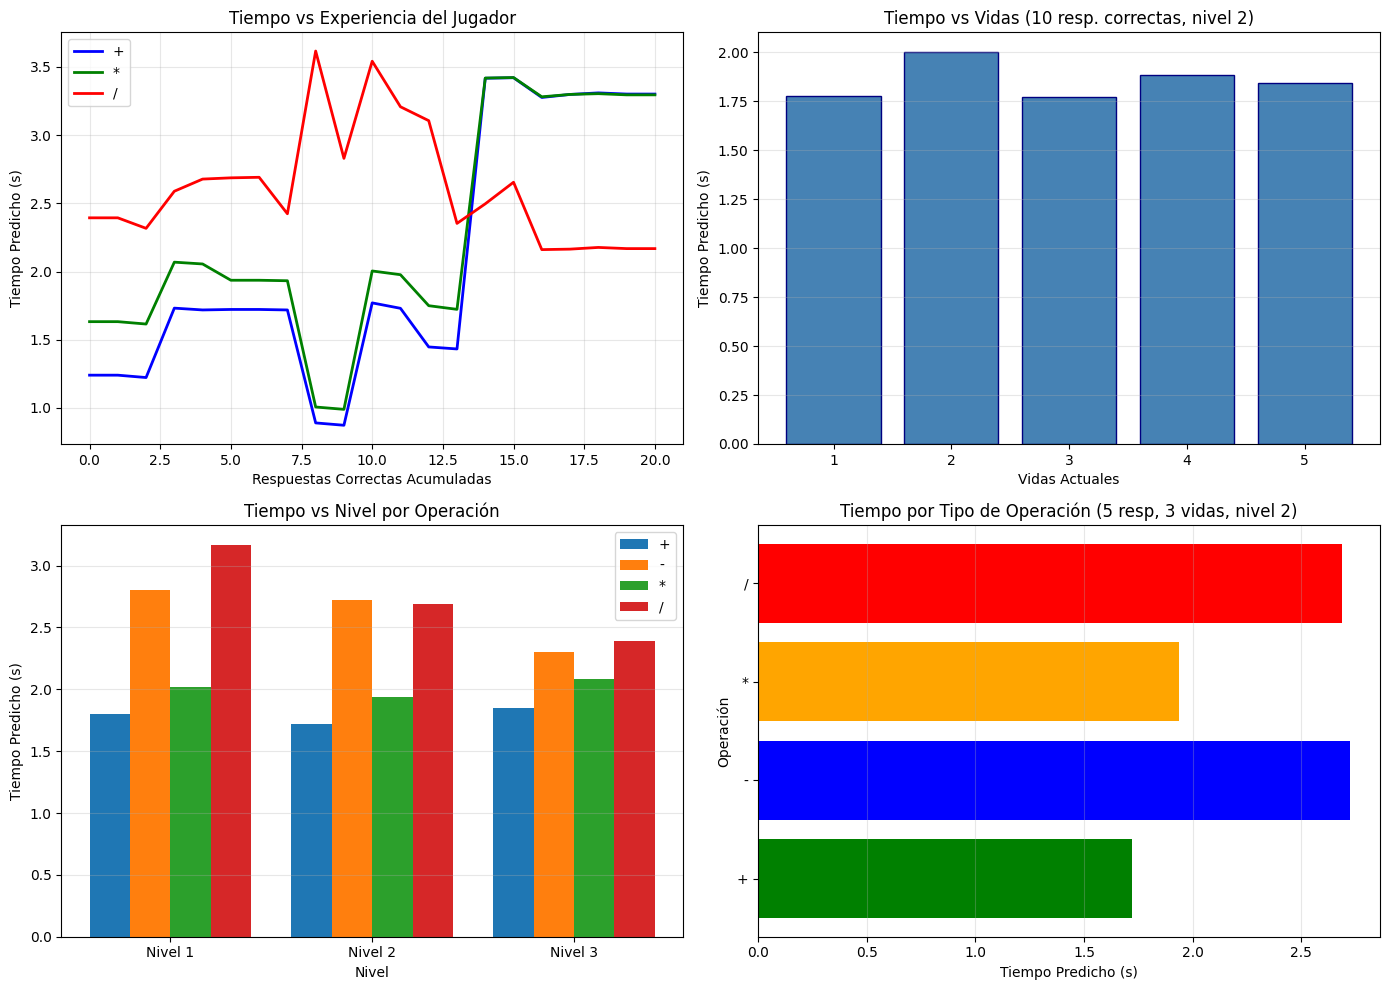


💾 Gráfico guardado como 'visualizacion_predicciones.png'


In [6]:
import matplotlib.pyplot as plt

def visualizar_predicciones():
    """
    Visualiza cómo varía el tiempo predicho según diferentes variables
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # 1. Tiempo vs Respuestas Correctas
    respuestas = range(0, 21)
    tiempos_suma = [sistema.predecir_tiempo('+', r, 3, 2) for r in respuestas]
    tiempos_mult = [sistema.predecir_tiempo('*', r, 3, 2) for r in respuestas]
    tiempos_div = [sistema.predecir_tiempo('/', r, 3, 2) for r in respuestas]
    
    axes[0, 0].plot(respuestas, tiempos_suma, 'b-', label='+', linewidth=2)
    axes[0, 0].plot(respuestas, tiempos_mult, 'g-', label='*', linewidth=2)
    axes[0, 0].plot(respuestas, tiempos_div, 'r-', label='/', linewidth=2)
    axes[0, 0].set_xlabel('Respuestas Correctas Acumuladas')
    axes[0, 0].set_ylabel('Tiempo Predicho (s)')
    axes[0, 0].set_title('Tiempo vs Experiencia del Jugador')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Tiempo vs Vidas
    vidas = range(1, 6)
    tiempos_por_vida = [sistema.predecir_tiempo('+', 10, v, 2) for v in vidas]
    
    axes[0, 1].bar(vidas, tiempos_por_vida, color='steelblue', edgecolor='navy')
    axes[0, 1].set_xlabel('Vidas Actuales')
    axes[0, 1].set_ylabel('Tiempo Predicho (s)')
    axes[0, 1].set_title('Tiempo vs Vidas (10 resp. correctas, nivel 2)')
    axes[0, 1].set_xticks(list(vidas))
    axes[0, 1].grid(True, alpha=0.3, axis='y')
    
    # 3. Tiempo vs Nivel
    niveles = [1, 2, 3]
    operaciones = ['+', '-', '*', '/']
    
    x = np.arange(len(niveles))
    width = 0.2
    
    for i, op in enumerate(operaciones):
        tiempos = [sistema.predecir_tiempo(op, 5, 3, n) for n in niveles]
        axes[1, 0].bar(x + i*width, tiempos, width, label=op)
    
    axes[1, 0].set_xlabel('Nivel')
    axes[1, 0].set_ylabel('Tiempo Predicho (s)')
    axes[1, 0].set_title('Tiempo vs Nivel por Operación')
    axes[1, 0].set_xticks(x + width * 1.5)
    axes[1, 0].set_xticklabels(['Nivel 1', 'Nivel 2', 'Nivel 3'])
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3, axis='y')
    
    # 4. Comparación por Operación
    ops = ['+', '-', '*', '/']
    tiempos_ops = [sistema.predecir_tiempo(op, 5, 3, 2) for op in ops]
    colors = ['green', 'blue', 'orange', 'red']
    
    axes[1, 1].barh(ops, tiempos_ops, color=colors)
    axes[1, 1].set_xlabel('Tiempo Predicho (s)')
    axes[1, 1].set_ylabel('Operación')
    axes[1, 1].set_title('Tiempo por Tipo de Operación (5 resp, 3 vidas, nivel 2)')
    axes[1, 1].grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.savefig('visualizacion_predicciones.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("\n💾 Gráfico guardado como 'visualizacion_predicciones.png'")

visualizar_predicciones()

## 6. Simulación de una Partida Completa

In [7]:
def simular_partida(num_preguntas=10):
    """
    Simula una partida completa del juego con tiempo adaptativo
    """
    print("\n" + "="*70)
    print("🚀 SIMULACIÓN DE PARTIDA COMPLETA")
    print("="*70)
    
    # Estado inicial del juego
    vidas = 5
    puntaje = 0
    respuestas_correctas = 0
    nivel = 1
    operaciones = ['+', '-', '*', '/']
    
    # Reiniciar sistema de tiempo
    sistema_partida = TiempoAdaptativo(modelo)
    
    historial_partida = []
    
    print(f"\n🎮 Iniciando partida con {num_preguntas} preguntas...")
    print(f"❤️ Vidas iniciales: {vidas}")
    print("-"*70)
    
    for i in range(num_preguntas):
        if vidas <= 0:
            print("\n💀 ¡GAME OVER! Te quedaste sin vidas.")
            break
        
        # Determinar nivel basado en respuestas correctas
        if respuestas_correctas >= 10:
            nivel = 3
        elif respuestas_correctas >= 5:
            nivel = 2
        
        # Generar pregunta aleatoria
        signo = random.choice(operaciones)
        
        # Obtener tiempo predicho
        tiempo_asig, tiempo_pred = sistema_partida.obtener_tiempo_para_pregunta(
            signo, respuestas_correctas, vidas, nivel
        )
        
        # Simular respuesta del jugador (aleatorio)
        # Probabilidad de responder correctamente depende del nivel
        prob_correcta = 0.8 - (nivel * 0.1)  # 70%, 60%, 50% por nivel
        respuesta_correcta = random.random() < prob_correcta
        
        # Tiempo que tardó (simulado)
        if respuesta_correcta:
            tiempo_usado = tiempo_pred * random.uniform(0.5, 1.2)
        else:
            tiempo_usado = tiempo_pred * random.uniform(0.8, 1.5)
        
        tiempo_usado = round(tiempo_usado, 2)
        
        # Actualizar estado
        if respuesta_correcta:
            respuestas_correctas += 1
            puntaje += 10
            resultado = "✅"
        else:
            vidas -= 1
            puntaje -= 5
            resultado = "❌"
        
        # Registrar en el sistema adaptativo
        sistema_partida.registrar_respuesta(tiempo_usado, respuesta_correcta)
        
        # Guardar historial
        historial_partida.append({
            'Pregunta': i + 1,
            'Operación': signo,
            'Nivel': nivel,
            'Vidas': vidas + (1 if not respuesta_correcta else 0),
            'T. Predicho': tiempo_pred,
            'T. Asignado': tiempo_asig,
            'T. Usado': tiempo_usado,
            'Resultado': resultado
        })
        
        print(f"Pregunta {i+1}: {signo} | Nivel {nivel} | "
              f"T.Pred={tiempo_pred}s | T.Asig={tiempo_asig}s | "
              f"T.Usado={tiempo_usado}s | {resultado}")
    
    # Resumen final
    print("\n" + "="*70)
    print("📊 RESUMEN DE LA PARTIDA")
    print("="*70)
    print(f"🏆 Puntaje final: {puntaje}")
    print(f"✅ Respuestas correctas: {respuestas_correctas}")
    print(f"❤️ Vidas restantes: {max(0, vidas)}")
    print(f"📈 Nivel alcanzado: {nivel}")
    
    # Mostrar tabla
    df_partida = pd.DataFrame(historial_partida)
    print("\n📋 Historial detallado:")
    display(df_partida)
    
    return df_partida

# Ejecutar simulación
df_partida = simular_partida(15)


🚀 SIMULACIÓN DE PARTIDA COMPLETA

🎮 Iniciando partida con 15 preguntas...
❤️ Vidas iniciales: 5
----------------------------------------------------------------------
Pregunta 1: * | Nivel 1 | T.Pred=2.63s | T.Asig=2.63s | T.Usado=2.81s | ❌
Pregunta 2: / | Nivel 1 | T.Pred=2.8s | T.Asig=2.8s | T.Usado=2.09s | ✅
Pregunta 3: * | Nivel 1 | T.Pred=2.67s | T.Asig=2.67s | T.Usado=3.11s | ❌
Pregunta 4: * | Nivel 1 | T.Pred=1.6s | T.Asig=2.0s | T.Usado=2.08s | ❌
Pregunta 5: - | Nivel 1 | T.Pred=2.91s | T.Asig=2.76s | T.Usado=3.17s | ❌
Pregunta 6: - | Nivel 1 | T.Pred=1.9s | T.Asig=2.17s | T.Usado=1.53s | ✅
Pregunta 7: * | Nivel 1 | T.Pred=1.3s | T.Asig=2.0s | T.Usado=1.14s | ✅
Pregunta 8: / | Nivel 1 | T.Pred=1.87s | T.Asig=2.0s | T.Usado=1.77s | ✅
Pregunta 9: * | Nivel 1 | T.Pred=1.38s | T.Asig=2.0s | T.Usado=1.2s | ✅
Pregunta 10: - | Nivel 2 | T.Pred=1.91s | T.Asig=2.0s | T.Usado=2.08s | ✅
Pregunta 11: - | Nivel 2 | T.Pred=1.98s | T.Asig=2.0s | T.Usado=2.27s | ❌

💀 ¡GAME OVER! Te quedaste s

c:\Users\ASUS\miniconda3\envs\juego_nave\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
c:\Users\ASUS\miniconda3\envs\juego_nave\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
c:\Users\ASUS\miniconda3\envs\juego_nave\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
c:\Users\ASUS\miniconda3\envs\juego_nave\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
c:\Users\ASUS\miniconda3\envs\juego_nave\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not hav

,Pregunta,Operación,Nivel,Vidas,T. Predicho,T. Asignado,T. Usado,Resultado
0,1,*,1,5,2.63,2.63,2.81,❌
1,2,/,1,4,2.80,2.80,2.09,✅
2,3,*,1,4,2.67,2.67,3.11,❌
3,4,*,1,3,1.60,2.00,2.08,❌
4,5,-,1,2,2.91,2.76,3.17,❌
5,6,-,1,1,1.90,2.17,1.53,✅
6,7,*,1,1,1.30,2.00,1.14,✅
7,8,/,1,1,1.87,2.00,1.77,✅
8,9,*,1,1,1.38,2.00,1.20,✅
9,10,-,2,1,1.91,2.00,2.08,✅


## 7. Prueba Manual con Datos Personalizados

In [8]:
def prueba_personalizada():
    """
    Permite probar el modelo con datos personalizados
    """
    print("\n" + "="*60)
    print("🧪 PRUEBA PERSONALIZADA DEL MODELO")
    print("="*60)
    
    # Tabla de pruebas personalizadas
    print("\nIngrese múltiples escenarios para probar:")
    print("(Escriba 'fin' para terminar y ver resultados)\n")
    
    pruebas = []
    
    while True:
        entrada = input("Signo (+,-,*,/) o 'fin': ").strip()
        if entrada.lower() == 'fin':
            break
        
        if entrada not in ['+', '-', '*', '/']:
            print("❌ Signo inválido")
            continue
        
        try:
            resp = int(input("  Respuestas correctas: "))
            vidas = int(input("  Vidas: "))
            nivel = int(input("  Nivel: "))
            
            tiempo_asig, tiempo_pred = sistema.obtener_tiempo_para_pregunta(
                entrada, resp, vidas, nivel
            )
            
            pruebas.append({
                'Signo': entrada,
                'Resp. Correctas': resp,
                'Vidas': vidas,
                'Nivel': nivel,
                'Tiempo Predicho (s)': tiempo_pred,
                'Tiempo Asignado (s)': tiempo_asig
            })
            print(f"  ➡️ Tiempo predicho: {tiempo_pred}s | Asignado: {tiempo_asig}s\n")
            
        except ValueError:
            print("❌ Valor inválido\n")
    
    if pruebas:
        print("\n📊 RESULTADOS DE TODAS LAS PRUEBAS:")
        df_pruebas = pd.DataFrame(pruebas)
        display(df_pruebas)
        return df_pruebas
    
    return None

# Ejecutar prueba personalizada
# df_pruebas = prueba_personalizada()

## 8. Análisis del Comportamiento Adaptativo

In [9]:
def analizar_comportamiento_adaptativo():
    """
    Muestra cómo el sistema adapta el tiempo según el rendimiento
    """
    print("\n" + "="*70)
    print("📈 ANÁLISIS DEL COMPORTAMIENTO ADAPTATIVO")
    print("="*70)
    
    # Escenario 1: Jugador que mejora
    print("\n🎯 Escenario: Jugador que MEJORA progresivamente")
    print("-"*50)
    
    sistema_mejora = TiempoAdaptativo(modelo)
    
    for i in range(8):
        tiempo_asig, tiempo_pred = sistema_mejora.obtener_tiempo_para_pregunta('+', i*2, 5, 1)
        # Simular respuesta rápida y correcta
        tiempo_usado = tiempo_pred * 0.4
        sistema_mejora.registrar_respuesta(tiempo_usado, True)
        print(f"  Ronda {i+1}: T.Pred={tiempo_pred:.2f}s | T.Asig={tiempo_asig:.2f}s | "
              f"T.Usado={tiempo_usado:.2f}s | T.Base={sistema_mejora.tiempo_actual:.2f}s")
    
    # Escenario 2: Jugador con dificultades
    print("\n😰 Escenario: Jugador con DIFICULTADES")
    print("-"*50)
    
    sistema_dificil = TiempoAdaptativo(modelo)
    
    for i in range(8):
        tiempo_asig, tiempo_pred = sistema_dificil.obtener_tiempo_para_pregunta('/', i, 3, 2)
        # Simular respuesta lenta o incorrecta
        tiempo_usado = tiempo_pred * 1.3
        fue_correcta = i % 3 == 0  # Solo 1 de cada 3 correcta
        sistema_dificil.registrar_respuesta(tiempo_usado, fue_correcta)
        resultado = "✅" if fue_correcta else "❌"
        print(f"  Ronda {i+1}: T.Pred={tiempo_pred:.2f}s | T.Asig={tiempo_asig:.2f}s | "
              f"T.Usado={tiempo_usado:.2f}s | T.Base={sistema_dificil.tiempo_actual:.2f}s {resultado}")

analizar_comportamiento_adaptativo()


📈 ANÁLISIS DEL COMPORTAMIENTO ADAPTATIVO

🎯 Escenario: Jugador que MEJORA progresivamente
--------------------------------------------------
  Ronda 1: T.Pred=1.39s | T.Asig=2.00s | T.Usado=0.56s | T.Base=4.50s
  Ronda 2: T.Pred=1.34s | T.Asig=2.00s | T.Usado=0.54s | T.Base=4.00s
  Ronda 3: T.Pred=1.98s | T.Asig=2.00s | T.Usado=0.79s | T.Base=3.50s
  Ronda 4: T.Pred=1.97s | T.Asig=2.00s | T.Usado=0.79s | T.Base=3.00s
  Ronda 5: T.Pred=1.19s | T.Asig=2.00s | T.Usado=0.48s | T.Base=2.50s
  Ronda 6: T.Pred=2.03s | T.Asig=2.00s | T.Usado=0.81s | T.Base=2.00s
  Ronda 7: T.Pred=1.71s | T.Asig=2.00s | T.Usado=0.68s | T.Base=2.00s
  Ronda 8: T.Pred=3.65s | T.Asig=2.75s | T.Usado=1.46s | T.Base=2.00s

😰 Escenario: Jugador con DIFICULTADES
--------------------------------------------------
  Ronda 1: T.Pred=2.39s | T.Asig=2.39s | T.Usado=3.11s | T.Base=5.00s ✅
  Ronda 2: T.Pred=2.39s | T.Asig=2.39s | T.Usado=3.11s | T.Base=5.50s ❌
  Ronda 3: T.Pred=2.32s | T.Asig=2.32s | T.Usado=3.02s | T.Base=

c:\Users\ASUS\miniconda3\envs\juego_nave\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
c:\Users\ASUS\miniconda3\envs\juego_nave\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
c:\Users\ASUS\miniconda3\envs\juego_nave\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
c:\Users\ASUS\miniconda3\envs\juego_nave\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
c:\Users\ASUS\miniconda3\envs\juego_nave\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not hav

## 📋 Resumen del Simulador

In [10]:
print("\n" + "="*70)
print("📋 RESUMEN DEL SIMULADOR")
print("="*70)
print("""
✅ Modelo utilizado: Gradient Boosting (R² = 0.806)

📊 Variables de entrada:
   • signo_encoded: Tipo de operación (+, -, *, /)
   • respuestas_correctas_acumuladas: Experiencia del jugador
   • vidas_actuales: Estado de salud del jugador
   • nivel_actual: Dificultad del juego (1-3)

⏱️ Sistema adaptativo:
   • Si responde RÁPIDO y CORRECTO → Reduce tiempo siguiente
   • Si responde LENTO o INCORRECTO → Aumenta tiempo siguiente
   • Límites: Mínimo 2s, Máximo 10s

🎮 Funciones disponibles:
   1. predecir_tiempo_individual() - Predicción manual
   2. simular_escenarios() - Múltiples casos de prueba
   3. simular_partida(n) - Partida completa simulada
   4. prueba_personalizada() - Pruebas interactivas
   5. visualizar_predicciones() - Gráficos del modelo
   6. analizar_comportamiento_adaptativo() - Ver adaptación

🚀 ¡El sistema está listo para integrarse en el juego!
""")


📋 RESUMEN DEL SIMULADOR

✅ Modelo utilizado: Gradient Boosting (R² = 0.806)

📊 Variables de entrada:
   • signo_encoded: Tipo de operación (+, -, *, /)
   • respuestas_correctas_acumuladas: Experiencia del jugador
   • vidas_actuales: Estado de salud del jugador
   • nivel_actual: Dificultad del juego (1-3)

⏱️ Sistema adaptativo:
   • Si responde RÁPIDO y CORRECTO → Reduce tiempo siguiente
   • Si responde LENTO o INCORRECTO → Aumenta tiempo siguiente
   • Límites: Mínimo 2s, Máximo 10s

🎮 Funciones disponibles:
   1. predecir_tiempo_individual() - Predicción manual
   2. simular_escenarios() - Múltiples casos de prueba
   3. simular_partida(n) - Partida completa simulada
   4. prueba_personalizada() - Pruebas interactivas
   5. visualizar_predicciones() - Gráficos del modelo
   6. analizar_comportamiento_adaptativo() - Ver adaptación

🚀 ¡El sistema está listo para integrarse en el juego!

